In [1]:
####
#1 model version comparisons
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm

In [97]:
#Observations
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observations = xr.open_zarr(obs_path)
observations = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) #Same time?
observationsvals = observations.values
#6 Hour increments

In [26]:
#IFS ENS
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
forecast1 = xr.open_zarr(forecast_path)
forecast1
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [27]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [28]:
#IFSHRES
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
forecast3 = xr.open_zarr(forecast_path)
forecast3
#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
#ERA 5 forecast
forecast4 = xr.open_zarr('gs://weatherbench2/datasets/era5-forecasts/2020-64x32_equiangular_conservative.zarr')
forecast4
#12 Hour increments, pred 6 Hours #31

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 31,
                              longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int32 500 700 850
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 00:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    vertical_velocity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [ ]:
#Keisler GNN
forecast5 = xr.open_zarr('gs://weatherbench2/datasets/keisler/2020-64x32_equiangular_conservative.zarr')
forecast5

#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:               (level: 3, time: 732, prediction_timedelta: 41,
                           longitude: 64, latitude: 32)
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 500 700 850
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-31T12:...
Data variables:
    geopotential          (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    specific_humidity     (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    temperature           (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    u_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    v_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    wind_speed            (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>

In [ ]:
#Pangu Weather
forecast6 = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')
forecast6
#12 Hour increments, pred 6 Hours #40, no time = 0? Useable, just don't compute for time =0?
#When finding MSE at all lags could just not find for that specific lag
#When comparing paths,  

<xarray.Dataset>
Dimensions:                  (time: 3652, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2018-01-01 ... 2022-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
#Pangu Weather operational
forecast7 = xr.open_zarr('gs://weatherbench2/datasets/pangu_hres_init/2020_0012_64x32_equiangular_conservative.zarr')
forecast7
#12 Hour increments, pred 6 Hours #40, no time = 0 for pangu

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int64 1000 925 850 700 ... 200 150 100 50
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 06:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
#Graphcast
forecast8 = xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')
forecast8

#12 Hour increments, pred 6 Hours #40, no 0 time

<xarray.Dataset>
Dimensions:                   (time: 886, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int64 1 2 3 5 7 ... 900 925 950 975 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2019-11-16 ... 2021-01-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>

In [ ]:
#Graphcast operational
forecast9 = xr.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')
forecast9

#12 Hour increments, pred 6 Hours #40, no 0 time

<xarray.Dataset>
Dimensions:                   (time: 732, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 06:00:00...
  * time                      (time) datetime64[ns] 2020-01-01 ... 2020-12-31...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
#Spherical CNN
forecast10 = xr.open_zarr('gs://weatherbench2/datasets/sphericalcnn/2020-64x32_equiangular_conservative.zarr')
forecast10
#2 Day increments, pred 6 Hours #40, no time 0

<xarray.Dataset>
Dimensions:               (time: 178, prediction_timedelta: 40, level: 13,
                           longitude: 64, latitude: 32)
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 50 100 150 200 250 ... 700 850 925 1000
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days 06:00...
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-20
Data variables:
    geopotential          (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    specific_humidity     (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    temperature           (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind   (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind   (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>
    wind_speed            (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(10, 40, 13, 64, 32), meta=np.ndarray>

In [ ]:
#Fuxi
forecast11 = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')
forecast11

#12 Hour increments, pred 6 Hours #60, no time 0

<xarray.Dataset>
Dimensions:                            (time: 702, prediction_timedelta: 60,
                                        longitude: 64, latitude: 32, level: 2)
Coordinates:
  * latitude                           (latitude) float64 -87.19 ... 87.19
  * level                              (level) int32 500 850
  * longitude                          (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta               (prediction_timedelta) timedelta64[ns] ...
  * time                               (time) datetime64[ns] 2020-01-01 ... 2...
Data variables:
    10m_u_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_wind_speed                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    2m_temperature                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    geopotential                       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    temperature                        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    total_precipitation_24hr_from_6hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    total_precipitation_6hr            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    u_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    v_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    wind_speed                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>

In [ ]:
#NeuralGCM
forecast12 = xr.open_zarr('gs://weatherbench2/datasets/neuralgcm_deterministic/2020-64x32_equiangular_conservative.zarr')
forecast12

#12 Hour increments, pred 12 Hours #31 so quivalent to #61 at 6 hours halved


<xarray.Dataset>
Dimensions:                              (time: 732, prediction_timedelta: 31,
                                          longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                             (latitude) float64 -87.19 ... 87.19
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] ...
  * time                                 (time) datetime64[ns] 2020-01-01 ......
Data variables:
    P_minus_E_cumulative                 (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                           (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  67001173
    worker_id:      1

In [ ]:
#NeuralGCM ensenmble 
forecast13 = xr.open_zarr('gs://weatherbench2/datasets/neuralgcm_ens/2020-64x32_equiangular_conservative.zarr')
forecast13

#12 Hour increments, pred 12 Hours #31 so quivalent to #61 at 6 hours halved


<xarray.Dataset>
Dimensions:                              (realization: 50, time: 732,
                                          prediction_timedelta: 32, level: 37,
                                          longitude: 64, latitude: 32)
Coordinates:
  * latitude                             (latitude) float64 -87.19 ... 87.19
  * level                                (level) int64 1 2 3 5 ... 950 975 1000
  * longitude                            (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] ...
  * realization                          (realization) int64 0 1 2 ... 47 48 49
  * time                                 (time) datetime64[ns] 2020-01-01 ......
Data variables:
    geopotential                         (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    specific_humidity                    (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    temperature                          (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
    wind_speed                           (realization, time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(50, 4, 2, 1, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  73974210
    worker_id:      3

In [ ]:
allforecasts = [forecast1,forecast2,forecast3,forecast4,forecast5,forecast6,forecast7,forecast8,forecast9,forecast10,forecast11,forecast12,forecast13]
allforecasts = [val['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) for val in allforecasts]


In [ ]:
#First going over a specific place and weighting seperately with all models
forecast2vals = forecast2['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [ ]:
forecast2vals

(50, 61, 64, 32)

In [91]:
forecast1vals = forecast1['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [ ]:
#All models 

allforecasts[0][:,0,:,:,:]

<xarray.DataArray 'geopotential' (time: 50, prediction_timedelta: 61,
                                  longitude: 64, latitude: 32)>
dask.array<getitem, shape=(50, 61, 64, 32), dtype=float32, chunksize=(4, 1, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
    level                 int32 500
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
    number                int32 1
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-25T12:...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [73]:
def findscale(obs,fors):
    maxvalue = np.array([obs.max(),fors.max()]).max()

    return maxvalue

In [61]:
latitude = forecast1['latitude'][:].values
delta = 2.8125
theta_upper = latitude + delta
theta_lower = latitude - delta

# Calculate weights based on the provided formula
weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
weights /= weights.sum()
weights *= 32

weights

array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

In [69]:
grid = np.ones((64,32))
print(grid*weights)
forecast1

[[0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 ...
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]
 [0.07704437 0.23039114 0.38151911 ... 0.38151911 0.23039114 0.07704437]]


<xarray.Dataset>
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, longitude: 64,
                               latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * number                    (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 50, 1, 3, 64, 32), meta=np.ndarray>

In [241]:
def pkweighted(observations,forcasts,k):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcasts)
        observations = observations/max
        forcasts = forcasts/max

        static_kernel = sigkernel.Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcasts.shape[0]

        grid = np.zeros((64,32))
        cuda = torch.device('cuda') 
        for i in range(math.floor(time- 0.5*k)): #20
                for j in range(64):
                        print(j)
                        for l in range(32):
                            fors = forcasts[i,:,0:k+1,j,l]
                            obs = observations[2*i:2*i+k+1,j,l]
                            print(fors)
                            print(obs)

                            obs = np.expand_dims(obs, axis = 0)
                            
                            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                            X = torch.tensor(llfors, dtype=torch.double, device = cuda)
                            y = torch.tensor(llobs, dtype=torch.double, device = cuda)

                            val = signature_kernel.compute_scoring_rule(X,y).item()
                            grid[j,l] = val

        return (grid)

In [242]:
gridtest = pkweighted(observationsvals,forecast1vals,5)
#Very very slow, should be parallelisable 

0
[[0.84641755 0.84488285 0.8452613  0.84559417 0.8457747  0.8451149 ]
 [0.84675306 0.84509635 0.8451714  0.84559    0.84571505 0.84505826]
 [0.84626776 0.84453475 0.84467983 0.8449861  0.8449987  0.8445922 ]
 [0.8462428  0.8445725  0.84472924 0.8447878  0.84523225 0.8447487 ]
 [0.8466356  0.8448909  0.84498775 0.8451638  0.845465   0.8451324 ]
 [0.84645694 0.8447359  0.8450588  0.8454143  0.84577364 0.8453661 ]
 [0.8464511  0.8450723  0.84500575 0.84538585 0.8456763  0.84512246]
 [0.8465036  0.8447077  0.84460306 0.84458965 0.84490895 0.8444506 ]
 [0.84641236 0.84496075 0.84498787 0.8453247  0.845585   0.8450784 ]
 [0.8460439  0.8444018  0.84417415 0.8445818  0.84475434 0.8443196 ]
 [0.8464556  0.84478647 0.8448     0.845344   0.8456199  0.84497833]
 [0.84678036 0.8452313  0.8454505  0.84558934 0.8458571  0.845329  ]
 [0.8464677  0.8450103  0.8452865  0.84548175 0.8457233  0.8450148 ]
 [0.84665215 0.8450469  0.8452459  0.84548604 0.84564215 0.8453802 ]
 [0.8464538  0.8449217  0.844816

c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[0.97501236 0.9733392  0.9752961  0.9754326  0.9770878  0.9760836 ]
 [0.97512406 0.97334623 0.975458   0.9757199  0.97740924 0.9767059 ]
 [0.97522706 0.9734481  0.97517395 0.97516894 0.9771131  0.9765102 ]
 [0.97528744 0.9733705  0.9751292  0.9753016  0.9769975  0.9761403 ]
 [0.97527957 0.9735333  0.9756996  0.97532946 0.97720045 0.9761634 ]
 [0.97504896 0.9736178  0.97532105 0.97530645 0.9770793  0.9763551 ]
 [0.9753082  0.97375757 0.9753989  0.9755116  0.9769394  0.976337  ]
 [0.97514826 0.9736174  0.97534364 0.9757047  0.9776903  0.97710264]
 [0.9751679  0.97351635 0.9752158  0.97538245 0.9772422  0.97663736]
 [0.97505975 0.97345734 0.97513646 0.9753859  0.9766021  0.97611463]
 [0.9751016  0.9733408  0.9751857  0.9756775  0.9776568  0.97674143]
 [0.97534066 0.9738314  0.9753351  0.9752893  0.97688514 0.97575676]
 [0.9754066  0.973782   0.975497   0.97529477 0.97700214 0.9756722 ]
 [0.9752386  0.9735727  0.9752964  0.97537726 0.9772032  0.9764955 ]
 [0.9750711  0.97328675 0.9751407 

KeyboardInterrupt: 

In [126]:
forecast1vals.shape

(50, 50, 61, 64, 32)

In [139]:
def pksoloweighted(observations,forcastsolo,k):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcastsolo)
        observations = observations/max
        forcastsolo = forcastsolo/max

        static_kernel = sigkernel.Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcastsolo.shape[0]
        shiftedtime = math.floor(time- 0.5*k)
        print(shiftedtime)
        grid = np.zeros((shiftedtime, 64,32))

        for i in range(shiftedtime): #20
                print(i)
                for j in range(64):
                        for l in range(32):
                            fors = forcastsolo[i,0:k+1,j,l]
                            obs = observations[2*i:2*i+k+1,j,l]

                            fors = np.expand_dims(fors, axis = 0)
                            obs = np.expand_dims(obs, axis = 0)
                            
                            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                            X = torch.tensor(llfors, dtype=torch.double)
                            y = torch.tensor(llobs, dtype=torch.double)

                            val = signature_kernel.compute_scoring_rule(X,y).item()
                            grid[i,j,l] = val

        return (grid)

In [140]:
gridtest = pksoloweighted(observationsvals,forecast2vals,3)

48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [141]:
gridtest

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [296]:
def pksolosoloID(observations,forcastsolo,k,long,lat):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        max = findscale(observations, forcastsolo)
        print(max)
        observations = observations/max
        forcastsolo = forcastsolo/max

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcastsolo.shape[0]
        shiftedtime = math.floor(time- 0.5*k)

        grid = np.zeros((shiftedtime))
        j = long #0-63
        l= lat #0-31

        for i in range(shiftedtime): #20
            fors = forcastsolo[i,0:k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            #print(K_Xy.item())
            #print(-2*torch.mean(K_Xy))

            #val = signature_kernel.compute_scoring_rule(X,y).item()
            grid[i] = K_Xy.item()

        return (grid/shiftedtime)

In [233]:
def pksolosoloRBF2(observations,forcastsolo,k,long,lat):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        #max = findscale(observations, forcastsolo)
        #observations = observations/max
        #forcastsolo = forcastsolo/max

        static_kernel = sigkernel.RBFKernel(sigma=2)   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forcastsolo.shape[0]
        shiftedtime = math.floor(time- 0.5*k)

        grid = np.zeros((shiftedtime))
        j = long #0-63
        l= lat #0-31

        for i in range(shiftedtime): #20
            fors = forcastsolo[i,0:k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            #print(K_Xy.item())
            #print(-2*torch.mean(K_Xy))

            #val = signature_kernel.compute_scoring_rule(X,y).item()
            grid[i] = K_Xy.item()

        return (grid/shiftedtime)

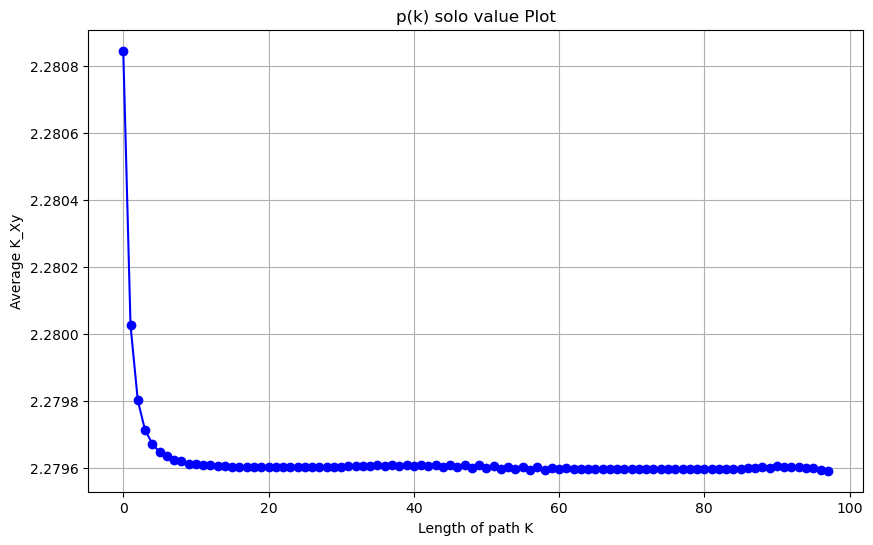

In [ ]:
#Graph at 20,15

#Smaller K_Xy is better

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,20,15))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

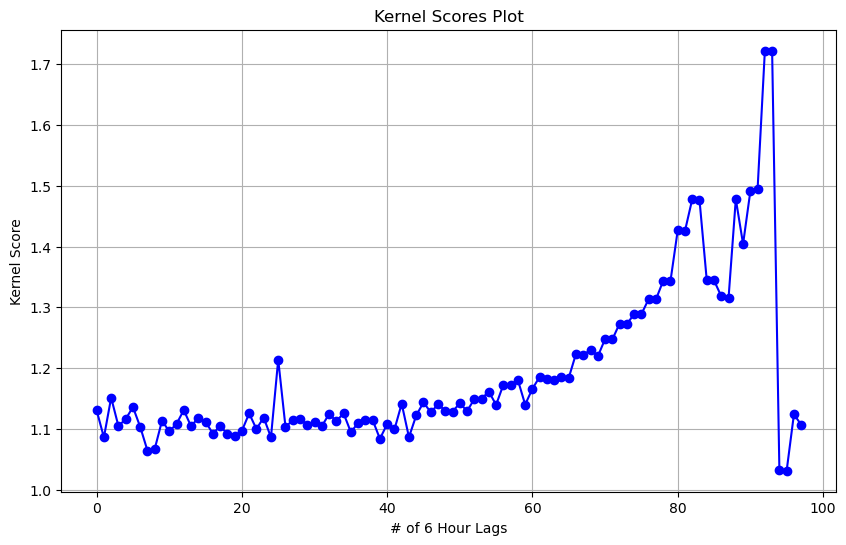

In [235]:
#Graph at 20,15

#RBF kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloRBF2(observationsvals,forecast2vals,k+1,20,15))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

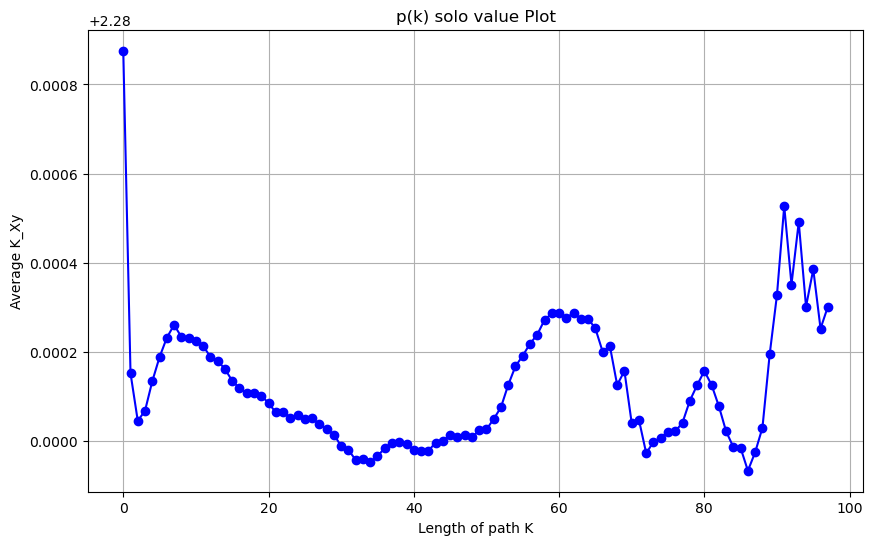

In [236]:
#Graph at 62,29
#Different points

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,62,29))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

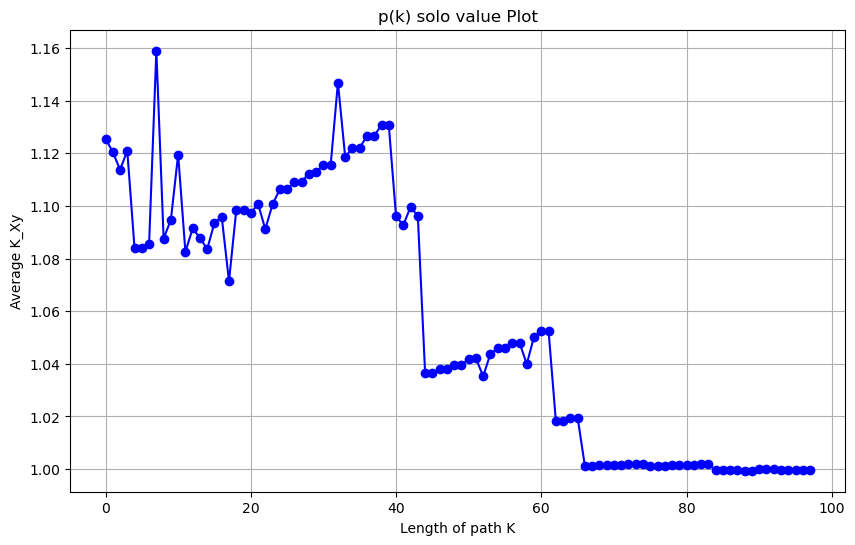

In [ ]:
#Graph at 62,29
#Different points

#RBF Kernel no scaling
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloRBF2(observationsvals,forecast2vals,k+1,62,29))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

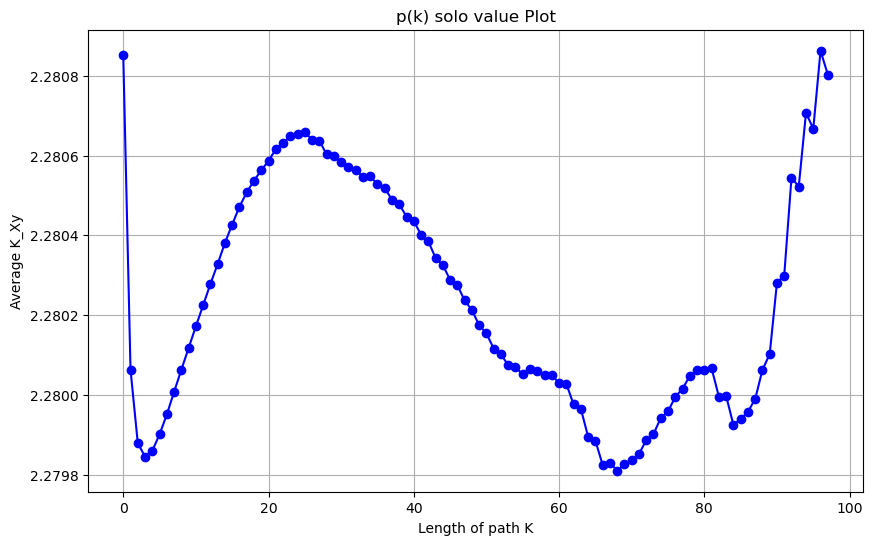

In [238]:
#Graph at 63,31
#Different points

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,63,31))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

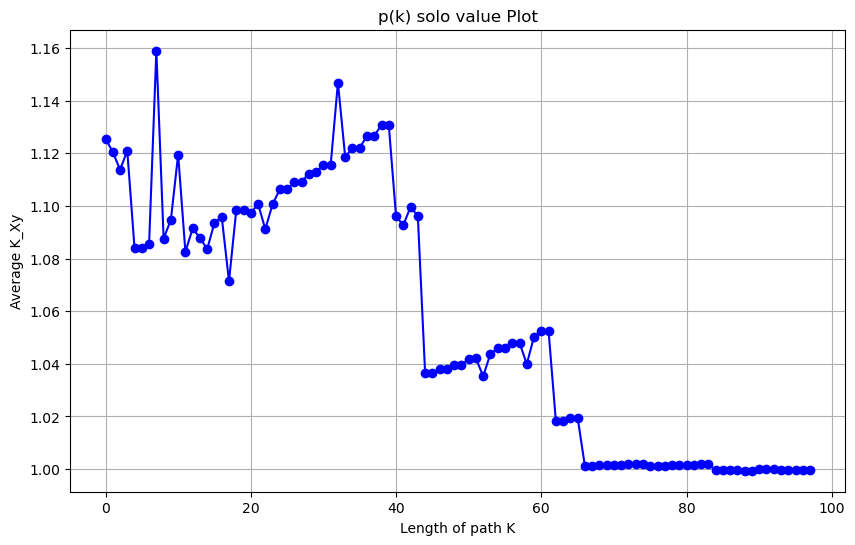

In [239]:
#Graph at 62,29
#Different points

#Identity Kernel
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloRBF2(observationsvals,forecast2vals,k+1,62,29))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

In [297]:
vals =[None]*98
for k in range(98):
    vals[k] = sum(pksolosoloID(observationsvals,forecast2vals,k+1,20,15))

plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(vals, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("p(k) solo value Plot")
plt.xlabel("Length of path K")
plt.ylabel("Average K_Xy")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484
58625.484


KeyboardInterrupt: 

In [ ]:
#Forecast 3 and Forecast 2
forecast2vals = forecast2['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

array([[[[49871.44 , 50181.46 , 50389.77 , ..., 49289.156, 48643.73 ,
          48313.37 ],
         [49855.53 , 50209.984, 50366.375, ..., 49323.266, 48670.95 ,
          48348.734],
         [49846.   , 50265.656, 50378.004, ..., 49284.11 , 48671.32 ,
          48373.965],
         ...,
         [49906.55 , 50259.387, 50400.77 , ..., 48840.215, 48313.434,
          48100.39 ],
         [49897.47 , 50214.094, 50442.574, ..., 49053.78 , 48469.895,
          48191.11 ],
         [49885.58 , 50185.137, 50422.363, ..., 49194.45 , 48572.594,
          48263.42 ]],

        [[49778.33 , 50109.18 , 50249.87 , ..., 49301.95 , 48672.586,
          48492.44 ],
         [49776.523, 50134.637, 50245.035, ..., 49357.953, 48714.56 ,
          48518.61 ],
         [49772.984, 50180.52 , 50255.906, ..., 49332.54 , 48719.254,
          48529.137],
         ...,
         [49762.297, 50141.31 , 50223.484, ..., 48714.09 , 48334.496,
          48321.75 ],
         [49771.074, 50116.36 , 50264.664, ..., 48

In [ ]:
forecast3vals = forecast3['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [523]:
forecast4vals = forecast4['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values

In [ ]:
forecast5vals = forecast5['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')).values


(50, 41, 64, 32)

In [247]:
print(forecast2vals.shape)
print(forecast3vals.shape)

(50, 61, 64, 32)
(50, 41, 64, 32)


In [ ]:
duo = [forecast2vals,forecast3vals]

array([[[[49871.44 , 50181.46 , 50389.77 , ..., 49289.156, 48643.73 ,
          48313.37 ],
         [49855.53 , 50209.984, 50366.375, ..., 49323.266, 48670.95 ,
          48348.734],
         [49846.   , 50265.656, 50378.004, ..., 49284.11 , 48671.32 ,
          48373.965],
         ...,
         [49906.55 , 50259.387, 50400.77 , ..., 48840.215, 48313.434,
          48100.39 ],
         [49897.47 , 50214.094, 50442.574, ..., 49053.78 , 48469.895,
          48191.11 ],
         [49885.58 , 50185.137, 50422.363, ..., 49194.45 , 48572.594,
          48263.42 ]],

        [[49778.33 , 50109.18 , 50249.87 , ..., 49301.95 , 48672.586,
          48492.44 ],
         [49776.523, 50134.637, 50245.035, ..., 49357.953, 48714.56 ,
          48518.61 ],
         [49772.984, 50180.52 , 50255.906, ..., 49332.54 , 48719.254,
          48529.137],
         ...,
         [49762.297, 50141.31 , 50223.484, ..., 48714.09 , 48334.496,
          48321.75 ],
         [49771.074, 50116.36 , 50264.664, ..., 48

In [306]:
len(duo)

2

[[[[49871.44  50181.46  50389.77  ... 49289.156 48643.73  48313.37 ]
   [49855.53  50209.984 50366.375 ... 49323.266 48670.95  48348.734]
   [49846.    50265.656 50378.004 ... 49284.11  48671.32  48373.965]
   ...
   [49906.55  50259.387 50400.77  ... 48840.215 48313.434 48100.39 ]
   [49897.47  50214.094 50442.574 ... 49053.78  48469.895 48191.11 ]
   [49885.58  50185.137 50422.363 ... 49194.45  48572.594 48263.42 ]]

  [[49778.33  50109.18  50249.87  ... 49301.95  48672.586 48492.44 ]
   [49776.523 50134.637 50245.035 ... 49357.953 48714.56  48518.61 ]
   [49772.984 50180.52  50255.906 ... 49332.54  48719.254 48529.137]
   ...
   [49762.297 50141.31  50223.484 ... 48714.09  48334.496 48321.75 ]
   [49771.074 50116.36  50264.664 ... 48977.56  48492.16  48393.484]
   [49776.42  50104.613 50267.297 ... 49172.613 48600.336 48450.39 ]]

  [[49785.26  50106.61  50196.16  ... 49297.816 48747.84  48656.79 ]
   [49802.6   50139.76  50199.395 ... 49372.57  48778.676 48672.855]
   [49818.06  50

In [258]:
def findscaleall(obs,fors):
    realmax = obs.max()
    for val in fors:
        realmax = np.array([val.max(),realmax]).max()

    return realmax

In [330]:
np.std(observationsvals)

3302.5408

In [334]:
def pkduo(observations,forecasts,k,long,lat):
    #Find more notes on function in ReframingSigKernel.ipynb
    #Ensure K is reasonalbe, not negative, integer only, not outside bounds >2
        # max = findscaleall(observations, forecasts)
        # observations = observations/max
        # for i in range(len(forecasts)):
        #      forecasts[i] = forecasts[i]/max

        j = long
        l= lat 

        meanobs = sum(observations[:,j,l]/len(observations[:,j,l]))

        observations = observations/meanobs
        for i in range(len(forecasts)):
              forecasts[i] = forecasts[i]/meanobs

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts[0].shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)


        vals = [None]*len(forecasts)

        count = 0
        for val in forecasts:
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = val[i,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                grid[i] = K_Xy.item()
            
            vals[count] = sum(grid/shiftedtime)
            count+=1
        
        return(vals)

        #return (forecasts)

In [356]:
#Need to fix output from list to array
def pkduominus(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        meanobs = sum(observations[:,j,l]/len(observations[:,j,l]))
        std = np.std(observations[:,j,l])
        observations = (observations-meanobs)/std
        
        for i in range(len(forecasts)):
              forecasts[i] = (forecasts[i]-meanobs)/std

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts[0].shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)


        vals = np.zeros(len(forecasts))

        count = 0
        for f in range(len(forecasts)):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[f][i,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                grid[i] = K_Xy.item()
            
            vals[count] = sum(grid/shiftedtime)
            count+=1
        
        return(vals)

In [368]:
test = pkduo(observationsvals,[forecast2vals,forecast3vals],5,20,15)

In [392]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,20,15)

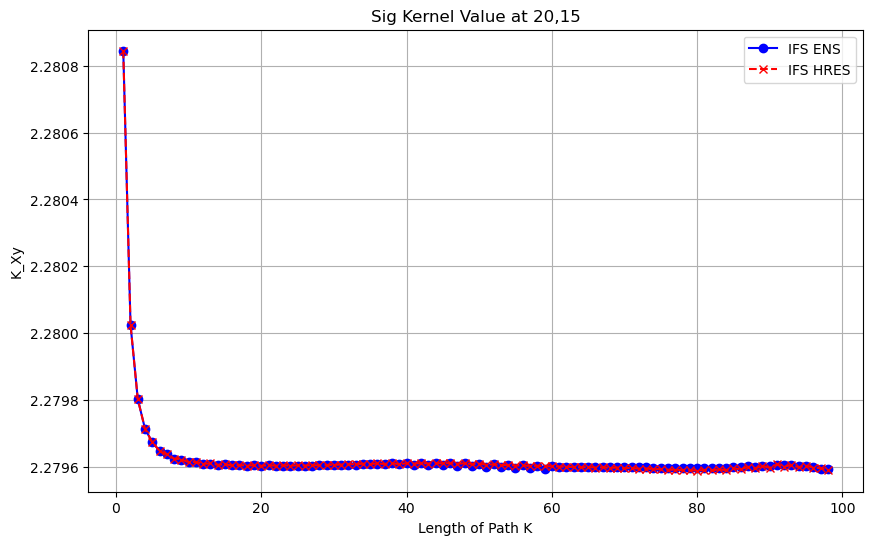

In [335]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,20,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 20,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

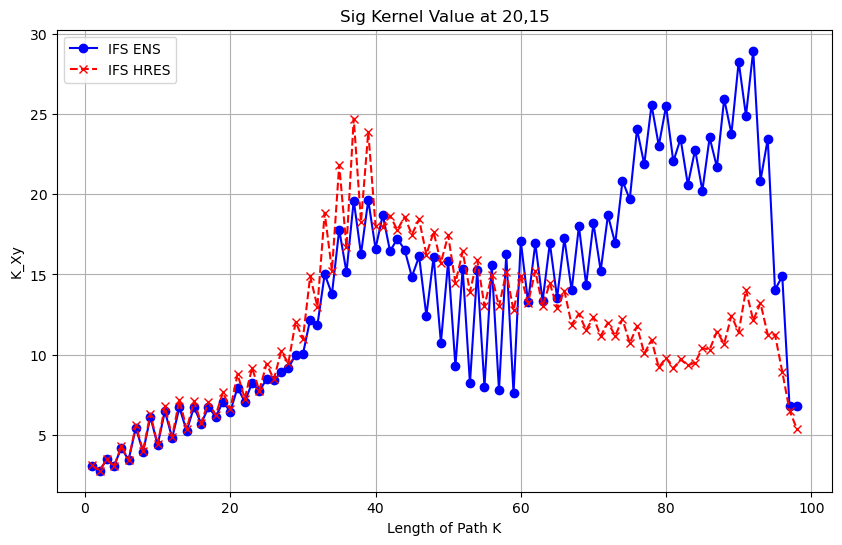

In [367]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,20,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 20,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

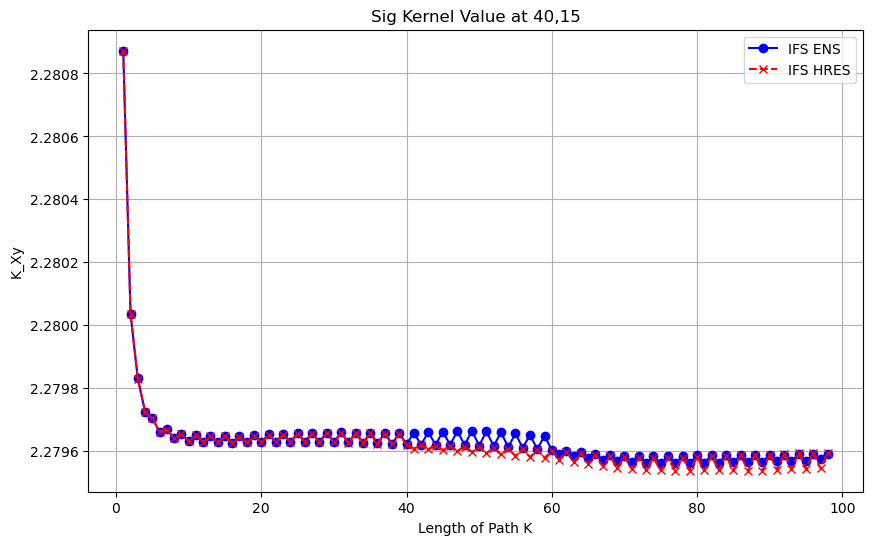

In [321]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,40,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 40,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

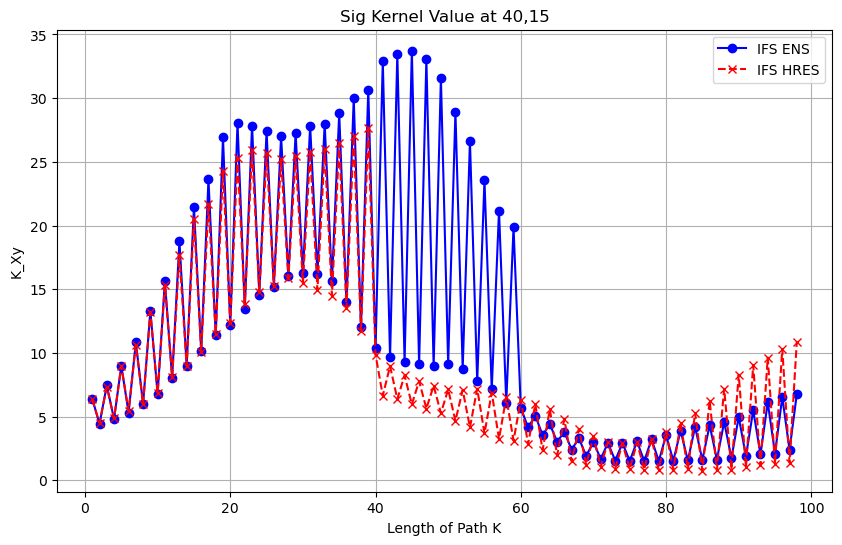

In [333]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,40,15)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 40,15")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

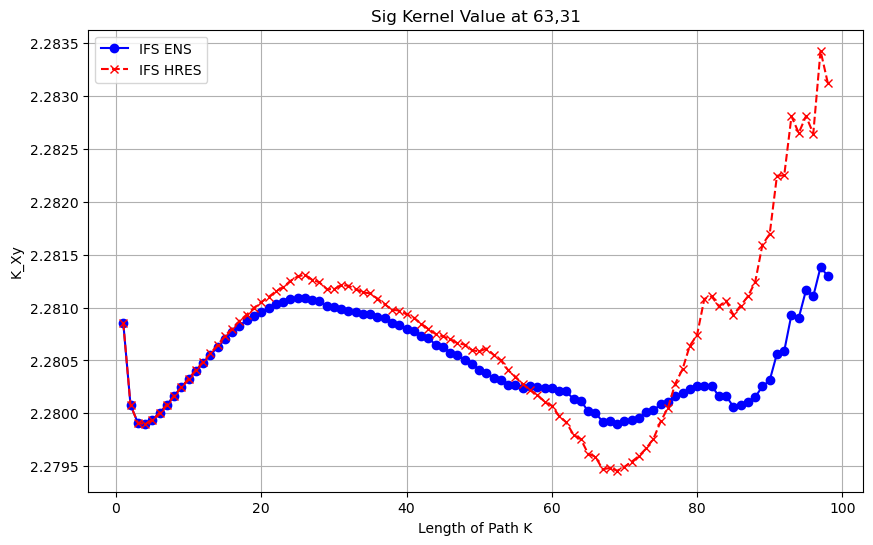

In [322]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

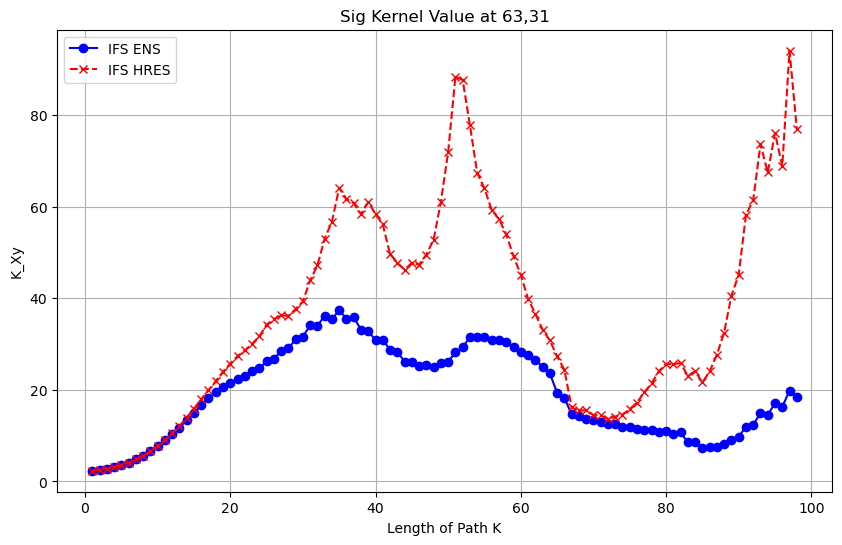

In [340]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

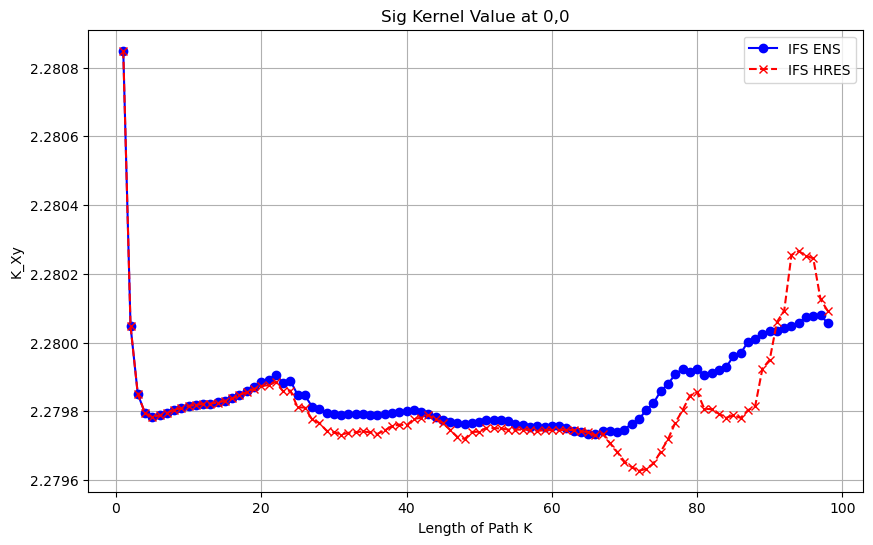

In [323]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,0,0)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 0,0")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

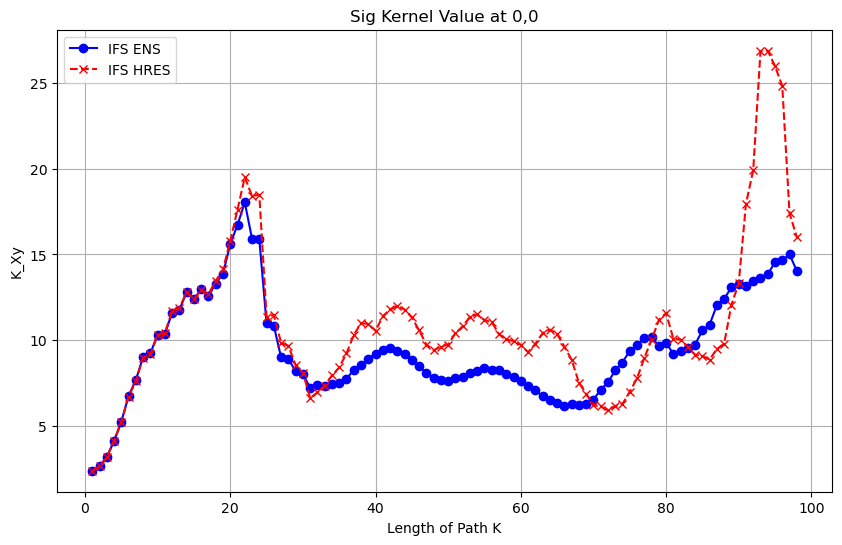

In [341]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,0,0)

first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 0,0")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

In [342]:
vals1 =[None]*98
vals2 =[None]*98
for k in range(98):
    vals1[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,0,0)
for k in range(98):
    vals2[k] = pkduominus(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)

In [ ]:
vals1 = [list(col) for col in zip(*vals1)]
vals2 = [list(col) for col in zip(*vals2)]
vals1

[[2.365462079984967,
  2.636758441663443,
  3.1620083858127885,
  4.097263370553598,
  5.2240080902271355,
  6.73254200901042,
  7.655462487954401,
  9.011267602360437,
  9.217332917779634,
  10.313627627681797,
  10.350211813055632,
  11.599057033925964,
  11.759869522071977,
  12.805586302269436,
  12.407658971468305,
  12.959299030064159,
  12.59018531310816,
  13.295407683614163,
  13.868379654810282,
  15.606720368683177,
  16.72569695147583,
  18.042273727738838,
  15.90654717593725,
  15.876165212316334,
  10.967863125469977,
  10.82959435619556,
  8.98282838941362,
  8.90157586540315,
  8.173611408859108,
  8.016424705768998,
  7.206879266908626,
  7.347315225081486,
  7.326912624009517,
  7.40678780901376,
  7.465599966408833,
  7.746794865333407,
  8.236841885210804,
  8.529151603183873,
  8.898772791389836,
  9.191984009100004,
  9.438678139013021,
  9.543555490314985,
  9.364954435323213,
  9.181521823332488,
  8.80518298040254,
  8.46042555203944,
  8.090963852048535,
  7.

In [413]:
sumcol1 = np.add(vals1[0],vals2[0])
sumcol2 = np.add(vals1[1],vals2[1])

array([ 4.70017675,  5.13379811,  5.91625172,  7.203615  ,  8.7744931 ,
       10.84568776, 12.45936032, 14.64051172, 15.81211203, 18.0009908 ,
       19.31219903, 21.91353179, 23.53151555, 26.12006634, 27.29996409,
       29.61215261, 30.76551697, 32.87304827, 34.50983467, 37.07294821,
       39.13701378, 41.121129  , 40.01645737, 40.56229753, 37.17404825,
       37.62040418, 37.48003528, 37.99160166, 39.18531009, 39.67001546,
       41.3157744 , 41.34731084, 43.53048074, 42.89321683, 44.85197186,
       43.33621891, 44.09809474, 41.70308431, 41.8201091 , 39.99309621,
       40.32770454, 38.30304119, 37.71729164, 35.38060187, 34.89064552,
       33.62809838, 33.57390419, 32.84284296, 33.42053873, 33.79710515,
       35.930697  , 37.19711689, 39.58519247, 39.78280074, 39.88421572,
       39.19084977, 39.10477624, 38.48766145, 37.11947615, 35.94666674,
       34.94350761, 33.58500273, 31.84731164, 30.12470368, 25.67682642,
       24.35481714, 20.97340225, 20.52752693, 19.81944481, 19.82

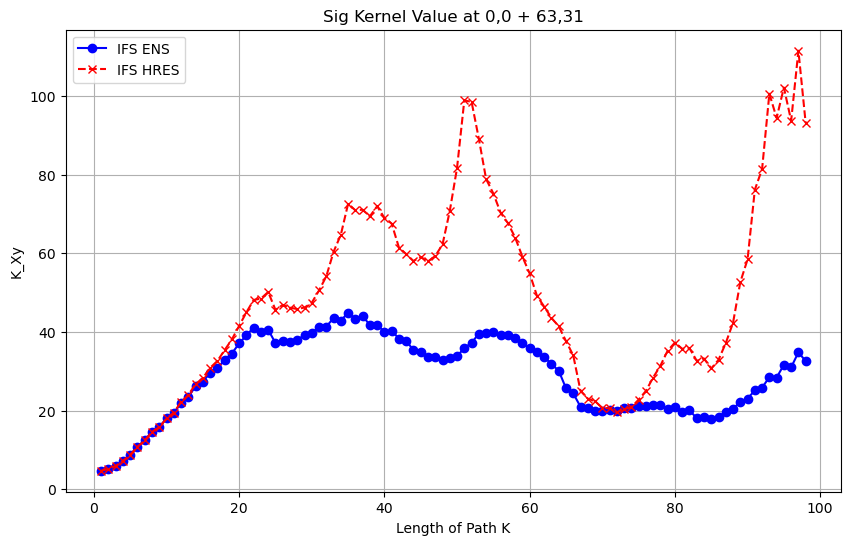

In [ ]:
first_elements = sumcol1
second_elements = sumcol2
x_values = range(1, len(sumcol2) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 0,0 + 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [534]:
#Iterate over all latitude values for a specific longitutde. Apply weighting. Fix outputs. 
#Scale all points by same, or can different positions be scaled?
def scalemean(observations):
      return (np.sum(observations/np.size(observations)))

def scalestd(observations):
      return (np.std(observations))

def scaleall(observations, forecasts):
      mean = scalemean(observations)
      std = scalestd(observations)
      observations = (observations-mean)/std
      for i in range(len(forecasts)):
              forecasts[i] = (forecasts[i]-mean)/std
      return([observations,forecasts])

 
def pkscaleall(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts[0].shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(len(forecasts))

        count = 0
        for f in range(len(forecasts)):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[f][i,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                grid[i] = K_Xy.item()
            
            vals[count] = sum(grid/shiftedtime)
            count+=1
        
        return(vals)

In [571]:
latitude = forecast1['latitude'][:].values
delta = 2.8125
theta_upper = latitude + delta
theta_lower = latitude - delta

# Calculate weights based on the provided formula
weights = (np.sin(np.radians(theta_upper)) - np.sin(np.radians(theta_lower)))
weights /= weights.sum()
weights *= 32

weights

array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

In [580]:
quad = [forecast2vals,forecast3vals,forecast4vals,forecast5vals]
test = scaleall(observationsvals,quad)

grid = np.zeros((32,98,4))

for lat in range(32): #32
    for k in range(98): #98
        vals = pkscaleall(test[0],test[1],k+1,15,lat)
        
        for i in range(len(quad)):
            grid[lat,k,i] = vals[i]



In [581]:
grid

array([[[2.28191888, 2.28191204, 2.2820136 , 2.28210123],
        [2.28439727, 2.28441583, 2.28470361, 2.28475229],
        [2.28876008, 2.28872974, 2.28931973, 2.28962783],
        ...,
        [2.35698772, 2.38714008, 2.32286802, 2.25633451],
        [2.38228707, 2.34775041, 2.24064423, 2.29743492],
        [2.38463826, 2.34928214, 2.23884512, 2.29733528]],

       [[2.28160301, 2.28158873, 2.28159922, 2.28170747],
        [2.28311365, 2.28310287, 2.28320741, 2.28336654],
        [2.28594969, 2.28590777, 2.2860888 , 2.28643009],
        ...,
        [2.3234217 , 2.31475866, 2.36993434, 2.27002606],
        [2.36302047, 2.27271052, 2.29734577, 2.31346714],
        [2.36530005, 2.27256252, 2.2978406 , 2.31441014]],

       [[2.28203294, 2.28202102, 2.28200766, 2.28196076],
        [2.28463493, 2.28461318, 2.28455529, 2.28453494],
        [2.28879538, 2.28870761, 2.28877422, 2.28872369],
        ...,
        [2.40121019, 2.43146161, 2.46042587, 2.38939855],
        [2.39878973, 2.368487

In [ ]:
grid1 = (grid*weights.reshape(-1,1,1))

73.16936363803156

In [583]:
np.sum(grid1, axis=0)

array([[73.17217466, 73.16902325, 73.17316231, 73.16936364],
       [73.41404218, 73.41307254, 73.4180589 , 73.41155716],
       [73.8474359 , 73.84466126, 73.8453689 , 73.837133  ],
       [74.20459093, 74.2041692 , 74.20900961, 74.19350092],
       [74.6557735 , 74.6518601 , 74.6470739 , 74.63859827],
       [74.95513781, 74.95305741, 74.94598527, 74.93246519],
       [75.29094471, 75.28635848, 75.27564744, 75.27862086],
       [75.47137056, 75.4696685 , 75.46998587, 75.45369464],
       [75.68578029, 75.68079069, 75.68162122, 75.67443616],
       [75.76021515, 75.76461677, 75.77716179, 75.74964978],
       [75.87768819, 75.88152161, 75.86379028, 75.86097574],
       [75.86992259, 75.88535127, 75.86141592, 75.84462824],
       [75.91391329, 75.94258519, 75.90162392, 75.90027245],
       [75.86025151, 75.8966144 , 75.88530305, 75.88320856],
       [75.88760769, 75.9224007 , 75.9069132 , 75.92033633],
       [75.84800396, 75.89648766, 75.86798195, 75.86243119],
       [75.90514395, 75.

In [584]:
vals = np.transpose(np.sum(grid1, axis=0))

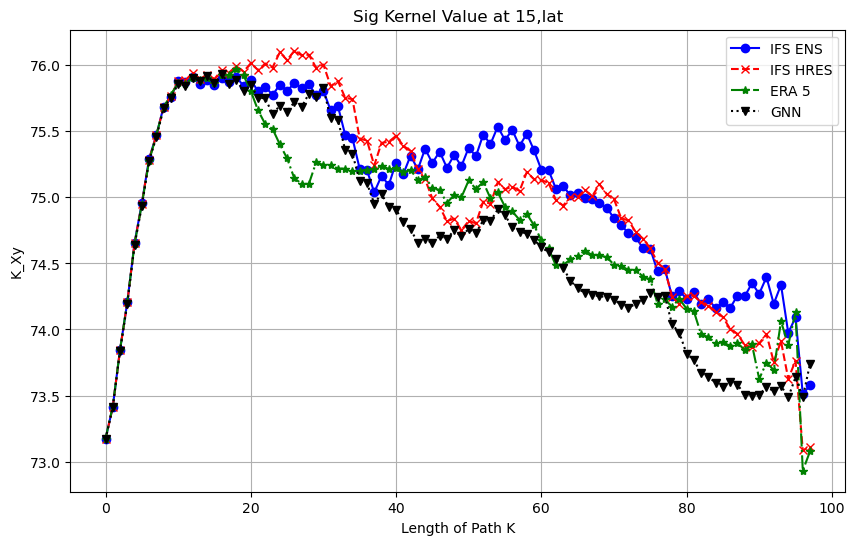

In [585]:
x_values = range(98)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, vals[0], marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, vals[1], marker='x', linestyle='--', color='r', label="IFS HRES")
plt.plot(x_values, vals[2], marker='*', linestyle='-.', color='g', label="ERA 5")
plt.plot(x_values, vals[3], marker='v', linestyle=':', color='k', label="GNN")


# Add titles and labels
plt.title("Sig Kernel Value at 15,lat")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

#Difficulty of scaling

#Why is zag zag happening?

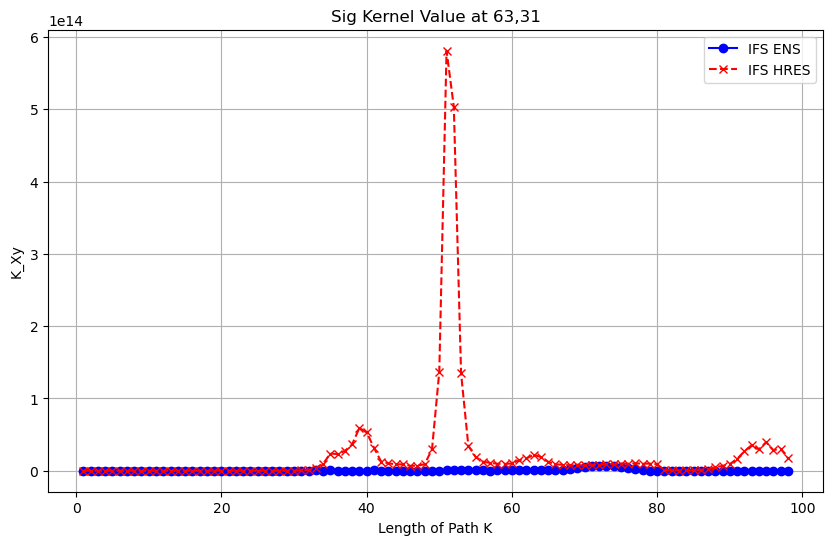

In [293]:
vals =[None]*98
for k in range(98):
    vals[k] = pkduo(observationsvals,[forecast2vals,forecast3vals],k+1,63,31)


first_elements = [pair[0] for pair in vals]
second_elements = [pair[1] for pair in vals]
x_values = range(1, len(vals) + 1)  # Assuming x-axis values are indices

# Plot
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(x_values, first_elements, marker='o', linestyle='-', color='b', label="IFS ENS")
plt.plot(x_values, second_elements, marker='x', linestyle='--', color='r', label="IFS HRES")

# Add titles and labels
plt.title("Sig Kernel Value at 63,31")
plt.xlabel("Length of Path K")
plt.ylabel("K_Xy")

# Add a legend
plt.legend()

# Optional: add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()